# Modeling Notebook

## Initial Setup

In [2]:
# Warning: this notebook takes significant time to run given all the model training

import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import class_weight
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D  
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.preprocessing import text, sequence
from keras.wrappers.scikit_learn import KerasClassifier
import pickle
import matplotlib.pyplot as plt
import time
from official.nlp import optimization
from os.path import exists
import shutil

# Importing Custom functions from code folder
import sys  
sys.path.insert(0, './code/')
import contraction
import data_preparation as dp
import visualizations as viz

params = {'axes.titlesize': 20,
          'axes.labelsize' : 16,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'font.size': 14,
          'figure.figsize': (12, 8)}
plt.rcParams.update(params)

### Loading Data

In [3]:
data = pd.read_csv('./data/clean_data.zip')

In [4]:
data.head()

,label,cleaned_text,cleaned_title,no_stop_text,topic_number,topic_labels
0,fake,sponsored links republican attacks on transgen...,virginia republican wants schools to check chi...,sponsored links republican attacks transgender...,5,Music
1,fake,mental images my pictures ask where does the t...,mental images,mental images pictures ask truth end lies begi...,4,Foreign News
2,fake,but it appears not all mr zuckerbergs own empl...,denzel washington hit by facebook fake news st...,appears mr zuckerbergs employees satisfied res...,2,Government
3,fake,genius nickname email password by clicking cre...,song lyrics knowledge,genius nickname email password clicking create...,1,Movies and TV
4,fake,getting ballot access can be hard for smaller ...,thinking about writing in a candidate on elect...,getting ballot access hard smaller campaigns f...,5,Music


### Encoding and Spliting

In [5]:
label = LabelEncoder()
X = data['cleaned_text']
y = label.fit_transform(data['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## TF-IDF Models

Our first models will used TF-IDF to embed the full text combined with various categorical machine learning models to predict whether the articles are fake or real stories. We will use 1000 TD-IDF vectors because anymore will substantially increase the training time of the Random Forest and XGBoost models. It is likely that the bayesian and logistic models coold see some substantial performance increases with more vectors, without huge costs in training.

In [5]:
tfidf = TfidfVectorizer(max_features=1000)
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

### Naive Bayesian Model

The Naive Bayesian model has the worst performance in F1 score and accuracy of those we tested, but has relatively good performance for taking less than a second to train.

In [30]:
if not exists('./models/bayes_model.pickle'):
    bayes_model = MultinomialNB()
    bayes_cv = cross_val_score(bayes_model, X_train_vectorized, y_train)
    print(bayes_cv)
    tic = time.perf_counter()
    bayes_model.fit(X_train_vectorized, y_train)
    toc = time.perf_counter()
    print(f"Fit model in {toc - tic:0.4f} seconds")
    with open('./models/bayes_model.pickle', 'wb') as f:
        pickle.dump(bayes_model, f)

[0.80418987 0.8127772  0.80134013 0.80728577 0.80502076]
Fit model in 0.0319 seconds


In [31]:
with open('./models/bayes_model.pickle', 'rb') as file:
    bayes_model = pickle.load(file)

It also produces predicts and scores very quickly.

In [32]:
print('Training Scores:')
bayes_train_metrics = dp.get_scores(bayes_model, X_train_vectorized, y_train)
print(bayes_train_metrics)

Training Scores:


{'Accuracy': 0.8073496659242761,
 'Precision': 0.806966786782127,
 'Recall': 0.8073496659242761,
 'F1 Score': 0.8070704521379753}

In [33]:
print('Test Scores:')
bayes_test_metrics = dp.get_scores(bayes_model, X_test_vectorized, y_test)
print(bayes_test_metrics)

Test Scores:


{'Accuracy': 0.8062056469877699,
 'Precision': 0.805768543681682,
 'Recall': 0.8062056469877699,
 'F1 Score': 0.8057512159741653}

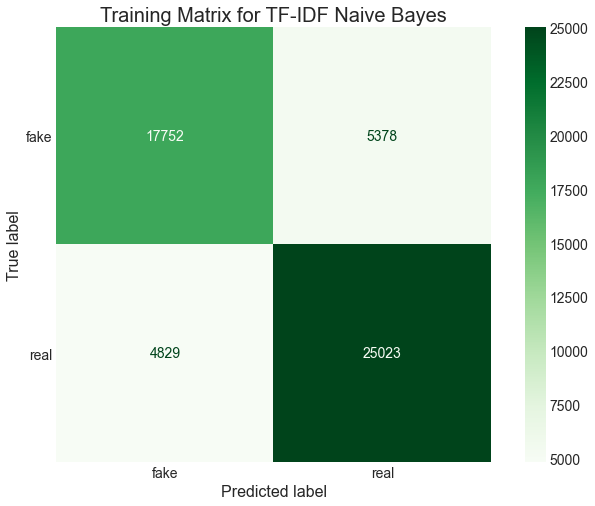

In [34]:
ConfusionMatrixDisplay.from_estimator(bayes_model, X_train_vectorized, y_train, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Training Matrix for TF-IDF Naive Bayes')
plt.savefig(f'images/Models/train_TFIDF_bayes.png')
plt.show()

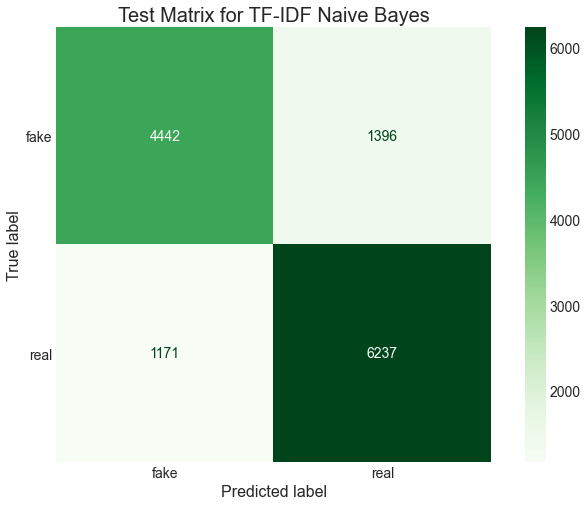

In [35]:
ConfusionMatrixDisplay.from_estimator(bayes_model, X_test_vectorized, y_test, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Test Matrix for TF-IDF Naive Bayes')
plt.savefig(f'images/Models/test_TFIDF_bayes.png')
plt.show()

### Logistic Model

The logisitic mode performs significantly better than the Bayesian model by F1 score and accuracy. It takes about 5 times longer to train, but that is still less than 2 seconds.

In [36]:
if not exists('./models/logistic_model.pickle'):
    logistic_model = LogisticRegression(max_iter=1000)
    logistic_cv = cross_val_score(logistic_model, X_train_vectorized, y_train)
    print(logistic_cv)
    tic = time.perf_counter()
    logistic_model.fit(X_train_vectorized, y_train)
    toc = time.perf_counter()
    print(f"Fit model in {toc - tic:0.4f} seconds")
    with open('./models/logistic_model.pickle', 'wb') as f:
        pickle.dump(logistic_model, f)

[0.87996603 0.89110126 0.88976972 0.88372971 0.88212533]
Fit model in 1.7701 seconds


In [37]:
with open('./models/logistic_model.pickle', 'rb') as file:
    logistic_model = pickle.load(file)

It also produces scores and predictions quickly.

In [38]:
print('Training Scores:')
log_train_metrics = dp.get_scores(logistic_model, X_train_vectorized, y_train)
print(log_train_metrics)

Training Scores:


{'Accuracy': 0.8927937790192896,
 'Precision': 0.8927301364920305,
 'Recall': 0.8927937790192896,
 'F1 Score': 0.892567671316183}

In [39]:
print('Test Scores:')
log_test_metrics = dp.get_scores(logistic_model, X_test_vectorized, y_test)
print(log_test_metrics)

Test Scores:


{'Accuracy': 0.8896270572248226,
 'Precision': 0.88972164112265,
 'Recall': 0.8896270572248226,
 'F1 Score': 0.8893192294695682}

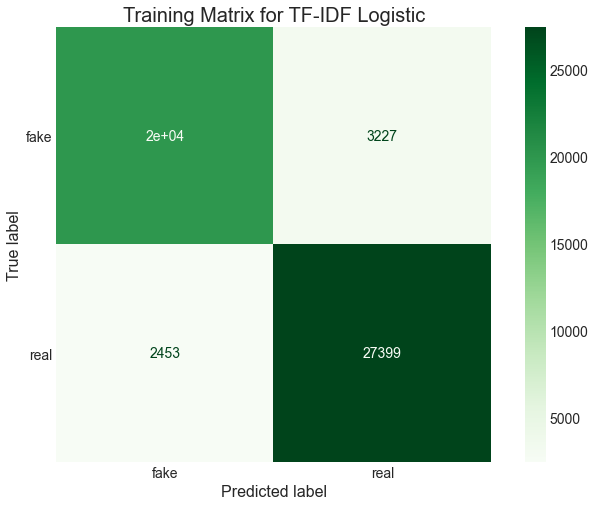

In [40]:
ConfusionMatrixDisplay.from_estimator(logistic_model, X_train_vectorized, y_train, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Training Matrix for TF-IDF Logistic')
plt.savefig(f'images/Models/train_TFIDF_logistic.png')
plt.show()

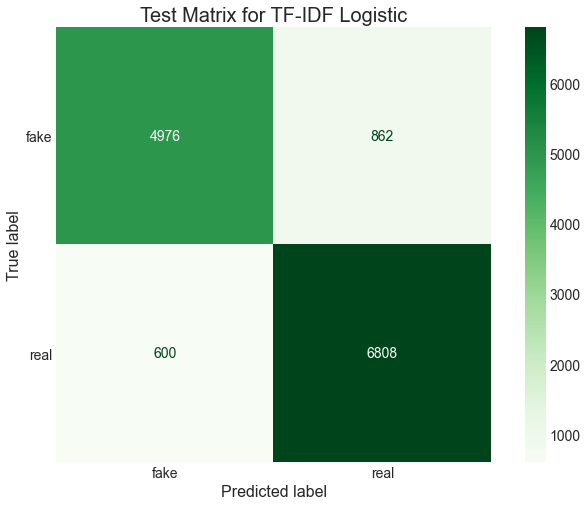

In [41]:
ConfusionMatrixDisplay.from_estimator(logistic_model, X_test_vectorized, y_test, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Test Matrix for TF-IDF Logistic')
plt.savefig(f'images/Models/train_TFIDF_logistic.png')
plt.show()

### Random Forest Model

The random forest model performs the best of the non-network models, but takes a couple maginitudes longer to train than the bayesian and logistic models taking around 265 seconds to train on my laptop.

In [42]:
if not exists('./models/forest_model.pickle'):
    forest_model = RandomForestClassifier()
    forest_cv = cross_val_score(forest_model, X_train_vectorized, y_train, n_jobs=4)
    print(forest_cv)
    tic = time.perf_counter()
    forest_model.fit(X_train_vectorized, y_train)
    toc = time.perf_counter()
    print(f"Fit model in {toc - tic:0.4f} seconds")
    with open('./models/forest_model.pickle', 'wb') as f:
        pickle.dump(forest_model, f)

[0.90544494 0.91299424 0.90722914 0.91090978 0.90515289]
Fit model in 265.8442 seconds


In [43]:
with open('./models/forest_model.pickle', 'rb') as file:
    forest_model = pickle.load(file)

It's predictions take a bit longer to produce as well, but is not unreasonably slow.

In [44]:
print('Training Scores:')
forest_train_metrics = dp.get_scores(forest_model, X_train_vectorized, y_train)
print(forest_train_metrics)

Training Scores:


{'Accuracy': 0.9964704994148956,
 'Precision': 0.9964792750680905,
 'Recall': 0.9964704994148956,
 'F1 Score': 0.9964694228375306}

In [45]:
print('Test Scores:')
forest_test_metrics = dp.get_scores(forest_model, X_test_vectorized, y_test)
print(forest_test_metrics)

Test Scores:


{'Accuracy': 0.9193718858523328,
 'Precision': 0.9201479234255043,
 'Recall': 0.9193718858523328,
 'F1 Score': 0.9190391639822563}

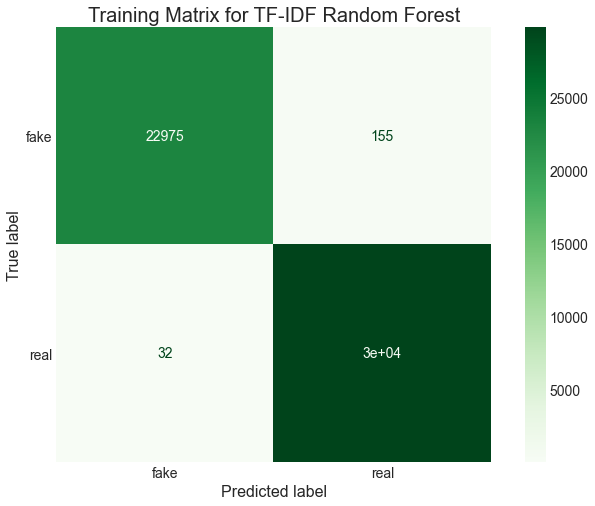

In [46]:
ConfusionMatrixDisplay.from_estimator(forest_model, X_train_vectorized, y_train, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Training Matrix for TF-IDF Random Forest')
plt.savefig(f'images/Models/train_TFIDF_forest.png')
plt.show()

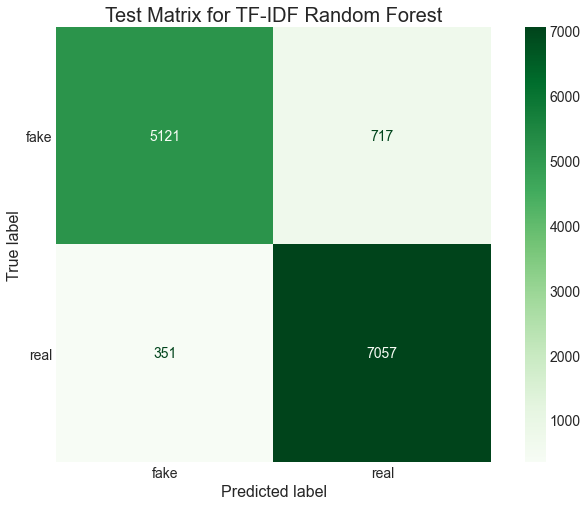

In [47]:
ConfusionMatrixDisplay.from_estimator(forest_model, X_test_vectorized, y_test, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Test Matrix for TF-IDF Random Forest')
plt.savefig(f'images/Models/train_TFIDF_forest.png')
plt.show()

### XGBoost Model

The XGBoost model perform almost as good as the random forest by F1 score and accuracy. It is much quicker to train, but still takes a couple order of magnitude more time to train than the logistic or bayesian at around 80 seconds on my machine.

In [48]:
if not exists('./models/xgb_model.pickle'):
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    xgb_cv = cross_val_score(xgb_model, X_train_vectorized, y_train)
    print(xgb_cv)
    tic = time.perf_counter()
    xgb_model.fit(X_train_vectorized, y_train)
    toc = time.perf_counter()
    print(f"Fit model in {toc - tic:0.4f} seconds")
    with open('./models/xgb_model.pickle', 'wb') as f:
        pickle.dump(xgb_model, f)

[0.9066717  0.91752383 0.90619102 0.9104379  0.90420914]
Fit model in 79.7310 seconds


In [49]:
with open('./models/xgb_model.pickle', 'rb') as file:
    xgb_model = pickle.load(file)

The predictions are done with reasonable speed.

In [50]:
print('Training Scores:')
xgb_train_metrics = dp.get_scores(xgb_model, X_train_vectorized, y_train)
print(xgb_train_metrics)

Training Scores:


{'Accuracy': 0.9597410441281945,
 'Precision': 0.9599398250735441,
 'Recall': 0.9597410441281945,
 'F1 Score': 0.9596637275519716}

In [51]:
print('Test Scores:')
xgb_test_metrics = dp.get_scores(xgb_model, X_test_vectorized, y_test)
print(xgb_test_metrics)

Test Scores:


{'Accuracy': 0.9146157330514872,
 'Precision': 0.9146243407429487,
 'Recall': 0.9146157330514872,
 'F1 Score': 0.9144720988798027}

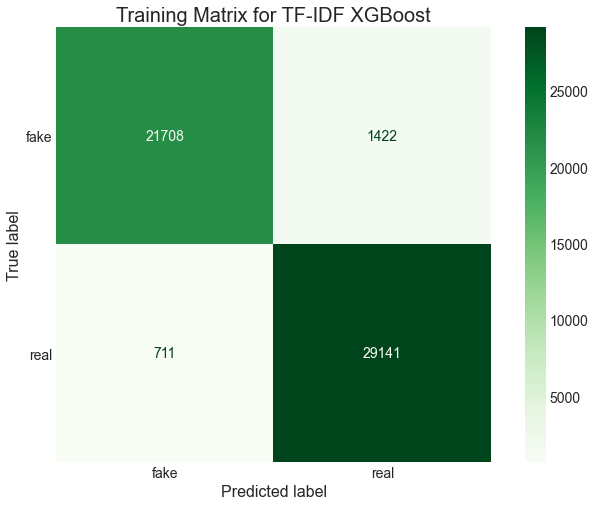

In [52]:
ConfusionMatrixDisplay.from_estimator(xgb_model, X_train_vectorized, y_train, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Training Matrix for TF-IDF XGBoost')
plt.savefig(f'images/Models/train_TFIDF_xgb.png')
plt.show()

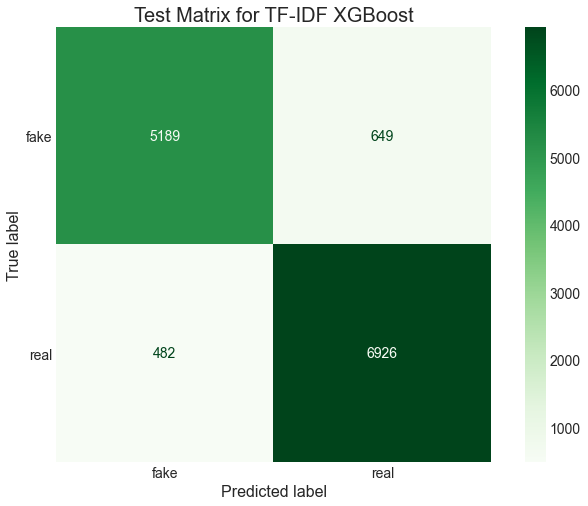

In [53]:
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test_vectorized, y_test, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Test Matrix for TF-IDF XGBoost')
plt.savefig(f'images/Models/train_TFIDF_xgb.png')
plt.show()

### Custom Trained Embedding

Our first network model will include an intially untrained embedding that will be trained only on the news stories themselves, along with a LSTM layer, and dense layer to aid in learning.

In [6]:
# Setting callback for training
callback = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [7]:
# One_hot encoding for easier model interpretation
y_one_hot = pd.get_dummies(data['label']).values
X_rnn = data['cleaned_text']
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_rnn, y_one_hot, test_size=0.2, random_state=42)

To begin we must tokenize and pad the text. We will choose a length of only 500 words for our sequences to decrease training time. Increasing to 1000 words would be reasonable if better hardware is being used, but we see quite good performance only using the first 500 words of the articles.

In [8]:
tokenizer = text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(list(X_train))
train_list_tokenized = tokenizer.texts_to_sequences(X_train_rnn)
X_train_padded = sequence.pad_sequences(train_list_tokenized, maxlen=500)
test_list_tokenized = tokenizer.texts_to_sequences(X_test_rnn)
X_test_padded = sequence.pad_sequences(test_list_tokenized, maxlen=500)

In [9]:
baseline_rnn = Sequential()
embedding_size = 200
baseline_rnn.add(Embedding(10000, embedding_size))
baseline_rnn.add(LSTM(100, return_sequences=True))
baseline_rnn.add(GlobalMaxPool1D())
baseline_rnn.add(Dropout(0.5))
baseline_rnn.add(Dense(100, activation='relu'))
baseline_rnn.add(Dropout(0.5))
baseline_rnn.add(Dense(2, activation='softmax'))
baseline_rnn.compile(loss='categorical_crossentropy', 
                              optimizer='adam', 
                              metrics=['accuracy'])
baseline_rnn.summary()
tf.keras.utils.plot_model(baseline_rnn)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2000000   
                                                                 
 lstm (LSTM)                 (None, None, 100)         120400    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                        

We can see that the neural networks take substantial time and computing resources to train.

In [9]:
if not exists('./models/baseline_rnn_model'):
    tic = time.perf_counter()
    baseline_rnn_val = baseline_rnn.fit(X_train_padded,
                                    y_train_rnn, 
                                    epochs=20, 
                                    batch_size=64, 
                                    validation_split=0.2,
                                    callbacks=[callback])
    toc = time.perf_counter()
    print(f"Fit model in {toc - tic:0.4f} seconds")
    baseline_rnn.save('./models/baseline_rnn_model')
    baseline_rnn_val_dict = baseline_rnn_val.history
    with open('./models/baseline_rnn_val_dict.pickle', 'wb') as f:
        pickle.dump(baseline_rnn_val_dict, f)

Epoch 1/20
663/663 [==============================] - 544s 820ms/step - loss: 0.3118 - accuracy: 0.8624 - val_loss: 0.2215 - val_accuracy: 0.9103
Epoch 2/20
663/663 [==============================] - 544s 821ms/step - loss: 0.1870 - accuracy: 0.9292 - val_loss: 0.2119 - val_accuracy: 0.9134
Epoch 3/20
663/663 [==============================] - 543s 819ms/step - loss: 0.1448 - accuracy: 0.9454 - val_loss: 0.2484 - val_accuracy: 0.9137
Epoch 4/20
663/663 [==============================] - 533s 804ms/step - loss: 0.1104 - accuracy: 0.9585 - val_loss: 0.2567 - val_accuracy: 0.9120
Fit model in 2168.8927 seconds
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models/baseline_rnn_model\assets


In [11]:
baseline_rnn = keras.models.load_model('models/baseline_rnn_model')
with open('./models/baseline_rnn_val_dict.pickle', 'rb') as file:
    baseline_rnn_val_dict = pickle.load(file)

It also takes more time to produce predictions, but performs a bit better than any ofthe non-network models.

In [12]:
baseline_metrics = dp.get_network_metrics(baseline_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn,
                                          batch_size = 64)

1656/1656 [==============================] - 157s 95ms/step - loss: 0.1434 - accuracy: 0.9507
----------
Training Loss: 0.143 
Training Accuracy: 0.951
Train Average Weighted F1 Score: 0.951
414/414 [==============================] - 41s 99ms/step - loss: 0.1969 - accuracy: 0.9200
----------
Test Loss: 0.197 
Test Accuracy: 0.92
Test Average Weighted F1 Score: 0.92


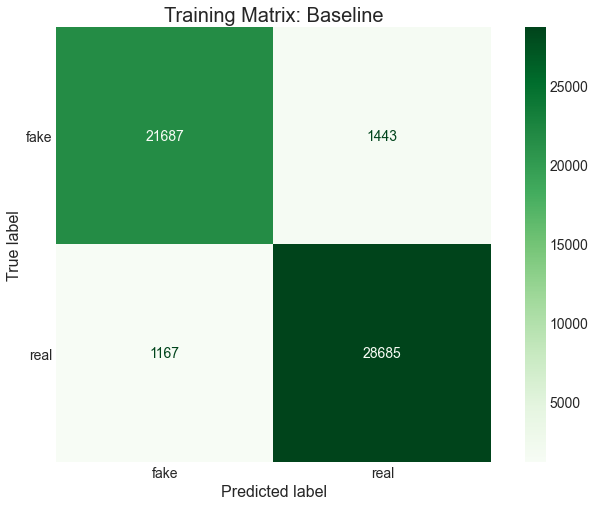

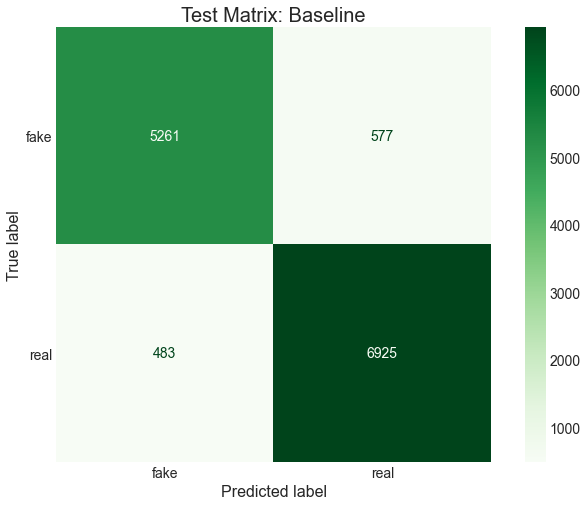

<Figure size 864x576 with 0 Axes>

In [13]:
viz.make_network_confusion_matrices(baseline_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'Baseline')

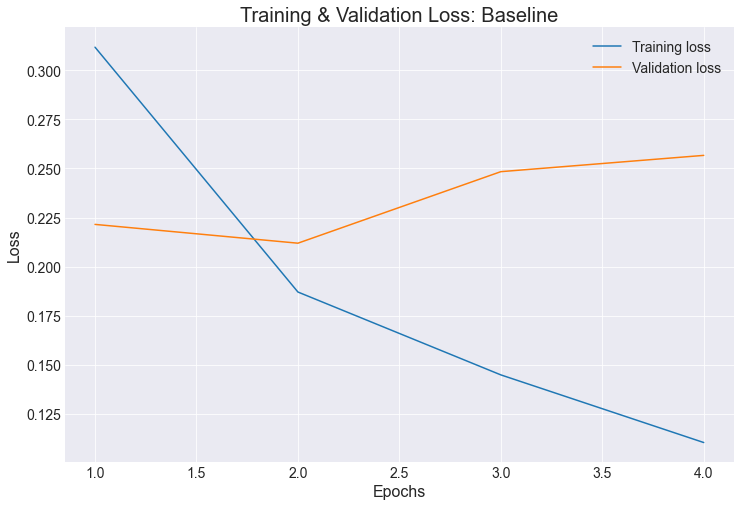

In [14]:
viz.training_graph(baseline_rnn_val_dict, 'Baseline')

### GloVe Model

GloVe is a pretrained word embedding availible online from: https://nlp.stanford.edu/projects/glove/. To train this model, glove.42B.300d.txt must be in the notebooks directory. 

To begin we will gather the index of all words in the training data, which is availible from the tokenizer we used above.

In [15]:
word_index = tokenizer.word_index
print('There are {} unique tokens in the dataset.'.format(len(word_index)))

There are 176704 unique tokens in the dataset.


Next, we will turn the downloaded txt documents containing the embedding vectors into a dictionary. 

In [16]:
glove = {}
with open('glove.42B.300d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in word_index.keys():
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

We will then use that dictionary to construct an embedding matrix.

In [17]:
embedding_matrix = np.zeros((len(word_index) + 1, 300)) # 300 dimensions since we used 300 dimensional glove vectors
for word, i in word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Finally, we will turn that matrix into an embedding layer that we will leave untrainable. All the training in this model will occur in the layers outside of the embedding. This will to some degree decrease training time since many of the parameters will not be factored directly into training.

In [18]:
embedding_layer = Embedding(len(word_index) + 1,
                            300,
                            weights=[embedding_matrix],
                            input_length=500,
                            trainable=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          53011500  
_________________________________________________________________
lstm_1 (LSTM)                (None, 500, 100)          160400    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

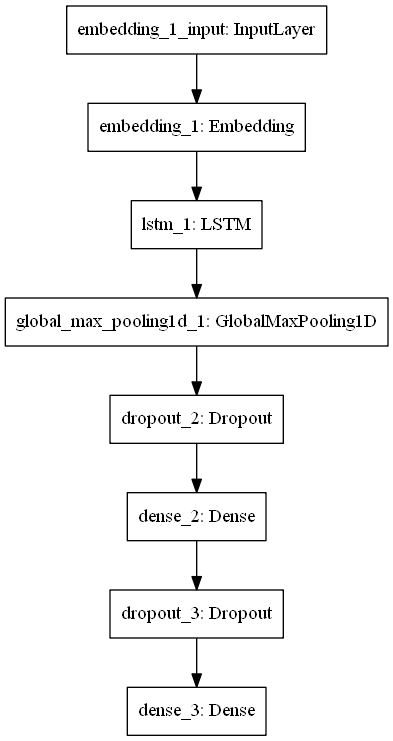

In [19]:
glove_rnn = Sequential()
glove_rnn.add(embedding_layer)
glove_rnn.add(LSTM(100, return_sequences=True))
glove_rnn.add(GlobalMaxPool1D())
glove_rnn.add(Dropout(0.5))
glove_rnn.add(Dense(100, activation='relu'))
glove_rnn.add(Dropout(0.5))
glove_rnn.add(Dense(2, activation='softmax'))
glove_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
glove_rnn.summary()
tf.keras.utils.plot_model(glove_rnn)

In [20]:
if not exists('./models/glove_rnn_model'):
    tic = time.perf_counter()
    glove_rnn_val = glove_rnn.fit(X_train_padded,
                              y_train_rnn,
                              epochs=20,
                              batch_size=64,
                              validation_split=0.2,
                              callbacks=[callback]) 
    toc = time.perf_counter()
    print(f"Fit model in {toc - tic:0.4f} seconds")
    glove_rnn.save('./models/glove_rnn_model')
    glove_rnn_val_dict = glove_rnn_val.history
    with open('./models/glove_rnn_val_dict.pickle', 'wb') as f:
        pickle.dump(glove_rnn_val_dict, f)

Epoch 1/20
663/663 [==============================] - 427s 645ms/step - loss: 0.3597 - accuracy: 0.8327 - val_loss: 0.2480 - val_accuracy: 0.8961
Epoch 2/20
663/663 [==============================] - 425s 640ms/step - loss: 0.2360 - accuracy: 0.9035 - val_loss: 0.2090 - val_accuracy: 0.9153
Epoch 3/20
663/663 [==============================] - 440s 663ms/step - loss: 0.2106 - accuracy: 0.9146 - val_loss: 0.2128 - val_accuracy: 0.9148
Epoch 4/20
663/663 [==============================] - 451s 681ms/step - loss: 0.1955 - accuracy: 0.9207 - val_loss: 0.1939 - val_accuracy: 0.9221
Epoch 5/20
663/663 [==============================] - 450s 679ms/step - loss: 0.1828 - accuracy: 0.9254 - val_loss: 0.1874 - val_accuracy: 0.9243
Epoch 6/20
663/663 [==============================] - 465s 701ms/step - loss: 0.1736 - accuracy: 0.9299 - val_loss: 0.1806 - val_accuracy: 0.9271
Epoch 7/20
663/663 [==============================] - 472s 712ms/step - loss: 0.1644 - accuracy: 0.9330 - val_loss: 0.1775 -

In [23]:
glove_rnn = keras.models.load_model('models/glove_rnn_model')
with open('./models/glove_rnn_val_dict.pickle', 'rb') as file:
    glove_rnn_val_dict = pickle.load(file)

In [25]:
glove_metrics = dp.get_network_metrics(glove_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn,
                                      batch_size = 64)

1656/1656 [==============================] - 316s 191ms/step - loss: 0.1407 - accuracy: 0.9442
----------
Training Loss: 0.141 
Training Accuracy: 0.944
Train Average Weighted F1 Score: 0.944
414/414 [==============================] - 76s 185ms/step - loss: 0.1620 - accuracy: 0.9364
----------
Test Loss: 0.162 
Test Accuracy: 0.936
Test Average Weighted F1 Score: 0.936


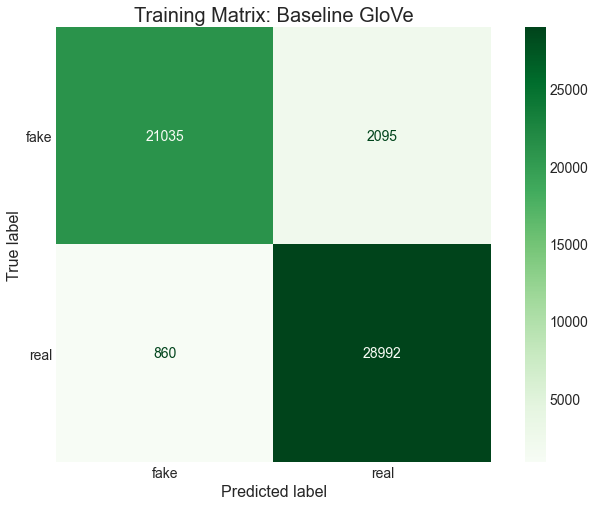

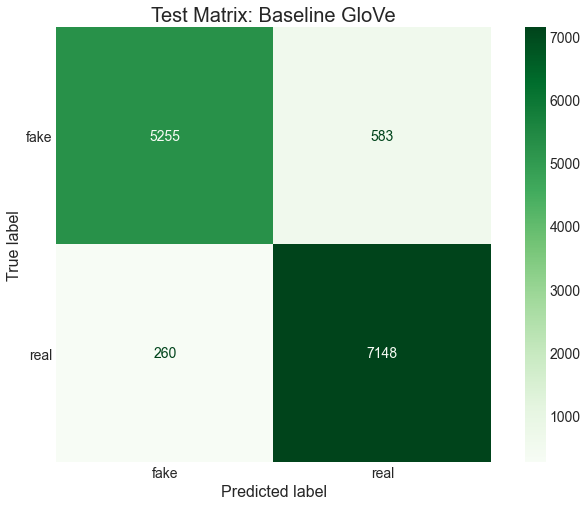

In [26]:
viz.make_network_confusion_matrices(glove_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'Baseline GloVe')

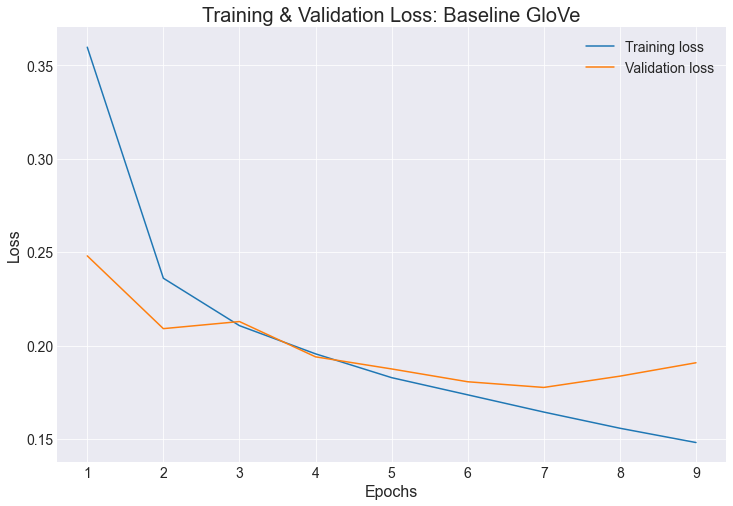

In [27]:
viz.training_graph(glove_rnn_val_dict, 'Baseline GloVe')

### BERT Model

In [10]:
tf.get_logger().setLevel('ERROR')

In [11]:
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'

In [12]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [13]:
text_test = ['donald trump is a reptile']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  6221  8398  2003  1037 16360 15286   102     0     0     0     0]
Input Mask : [1 1 1 1 1 1 1 1 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [14]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [15]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.99516016  0.93326855 -0.39727494  0.3521076  -0.6937658   0.03079522
  0.99859524 -0.93239963 -0.08098149  0.48975357 -0.05411101 -0.28774035]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.30527526 -0.12929238  0.55423844 ... -0.04532259  0.81051177
  -0.76545256]
 [ 0.85316217  0.9712938  -0.33219275 ... -0.9030604   0.23648828
   0.5340203 ]
 [-0.5338864   0.39022592  0.5818094  ... -0.47901815  0.9895912
  -0.6750735 ]
 ...
 [ 0.37269282  0.32463992  0.08277456 ... -0.17922552  0.7122086
   0.11111857]
 [ 0.09808467  0.05148305  0.1024198  ...  0.02831235  1.0540947
  -0.25039077]
 [ 0.136738    0.05480693 -0.18244812 ...  0.10303751  1.413619
  -0.7405467 ]]


In [29]:
def build_bert_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(100, activation='relu', name='learning')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    #We will be using the label encoded data, so the classifier with function as a binary classifier with one output
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net) 
    return tf.keras.Model(text_input, net)

In [30]:
bert_classifier_model = build_bert_classifier_model()
tf.keras.utils.plot_model(bert_classifier_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [31]:
epochs = 5
steps_per_epoch = X_train.shape[0]
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [32]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()
bert_classifier_model.compile(loss=loss, 
                              optimizer=optimizer, 
                              metrics=metrics)

In [34]:
# Bert preprocessing handles vectorizing/padding, so training on X_train, y_train which are raw values
if not exists('./models/bert_model'):
    print(f'Training model with {tfhub_handle_encoder}')
    tic = time.perf_counter()
    bert_val = bert_classifier_model.fit(X_train, 
                                         y_train,
                                         epochs=epochs,
                                         batch_size=64,
                                         validation_split=0.2,
                                         callbacks=[callback])
    toc = time.perf_counter()
    print(f"Fit model in {toc - tic:0.4f} seconds")
    bert_classifier_model.save('./models/bert_model')
    bert_val_dict = bert_val.history
    with open('./models/bert_val_dict.pickle', 'wb') as f:
        pickle.dump(bert_val_dict, f)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
663/663 [==============================] - 4248s 6s/step - loss: 0.6824 - binary_accuracy: 0.5305 - val_loss: 0.5386 - val_binary_accuracy: 0.7211
Epoch 2/5
663/663 [==============================] - 4352s 7s/step - loss: 0.4563 - binary_accuracy: 0.7629 - val_loss: 0.3402 - val_binary_accuracy: 0.8397
Epoch 3/5
663/663 [==============================] - 4270s 6s/step - loss: 0.3121 - binary_accuracy: 0.8564 - val_loss: 0.2720 - val_binary_accuracy: 0.8774
Epoch 4/5
663/663 [==============================] - 4137s 6s/step - loss: 0.2614 - binary_accuracy: 0.8847 - val_loss: 0.2472 - val_binary_accuracy: 0.8910
Epoch 5/5
663/663 [==============================] - 4295s 6s/step - loss: 0.2327 - binary_accuracy: 0.8996 - val_loss: 0.2343 - val_binary_accuracy: 0.8934
Fit model in 21303.1042 seconds


In [ ]:
bert_metrics = dp.get_network_metrics(bert_classifier_model, 
                                      X_train, 
                                      y_train, 
                                      X_test,
                                      y_test,
                                      batch_size = 64)

In [ ]:
viz.make_network_confusion_matrices(bert_classifier_model
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    labels = label.classes_,
                                    title = 'BERT Model',
                                    batch_size=64)

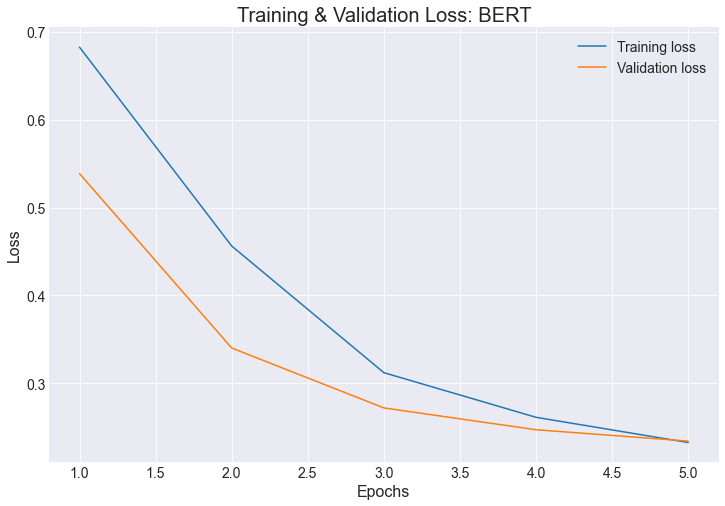

In [35]:
viz.training_graph(bert_val_dict, 'BERT')